In [3]:
from keras.optimizers import SGD
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pickle

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+19, 'gx'].values
    gy_values = train_df.loc[i:i+19, 'gy'].values
    gz_values = train_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append([gx_values, gy_values, gz_values])

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+19, 'gx'].values
    gy_values = test_df.loc[i:i+19, 'gy'].values
    gz_values = test_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append([gx_values, gy_values, gz_values])

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
y_test = onehot_encoder.transform(integer_encoded_test)

# LSTM 모델 정의
model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(3, 20)))  # 3개의 시퀀스, 각 시퀀스에 40개의 피처
model.add(keras.layers.Dense(5, activation='softmax'))  # 분류할 클래스 수에 맞게 조정

# 모델 컴파일 및 학습
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = history.model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_lstm.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_lstm.npy', label_encoder.classes_)

# 가중치를 로드하기 위해 모델 구성
loaded_model = keras.models.Sequential()
loaded_model.add(keras.layers.LSTM(128, input_shape=(3, 20)))  # 3개의 시퀀스, 각 시퀀스에 40개의 피처
loaded_model.add(keras.layers.Dense(5, activation='softmax'))  # 분류할 클래스 수에 맞게 조정

# 피클 파일에서 가중치 로드
loaded_model_weights = pickle.load(open('../model/best_model_weights_lstm.pkl', 'rb'))

# 모델에 로드된 가중치 설정
loaded_model.set_weights(loaded_model_weights)

# 모델 컴파일
loaded_model.compile(loss='binary_crossentropy',  optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])

# 모델 저장
loaded_model.save('../model/loaded_model_lstm.h5')

Epoch 1/100
856/856 [==============================] - 4s 3ms/step - loss: 0.3309 - accuracy: 0.6180 - val_loss: 0.2806 - val_accuracy: 0.6848
Epoch 2/100
856/856 [==============================] - 2s 2ms/step - loss: 0.2595 - accuracy: 0.6977 - val_loss: 0.2710 - val_accuracy: 0.6869
Epoch 3/100
856/856 [==============================] - 2s 3ms/step - loss: 0.2384 - accuracy: 0.7282 - val_loss: 0.2679 - val_accuracy: 0.6962
Epoch 4/100
856/856 [==============================] - 2s 2ms/step - loss: 0.2247 - accuracy: 0.7482 - val_loss: 0.2666 - val_accuracy: 0.6988
Epoch 5/100
856/856 [==============================] - 2s 3ms/step - loss: 0.2142 - accuracy: 0.7649 - val_loss: 0.2782 - val_accuracy: 0.6880
Epoch 6/100
856/856 [==============================] - 2s 2ms/step - loss: 0.2040 - accuracy: 0.7778 - val_loss: 0.2717 - val_accuracy: 0.7006
Epoch 7/100
856/856 [==============================] - 2s 2ms/step - loss: 0.1947 - accuracy: 0.7917 - val_loss: 0.2757 - val_accuracy: 0.6959

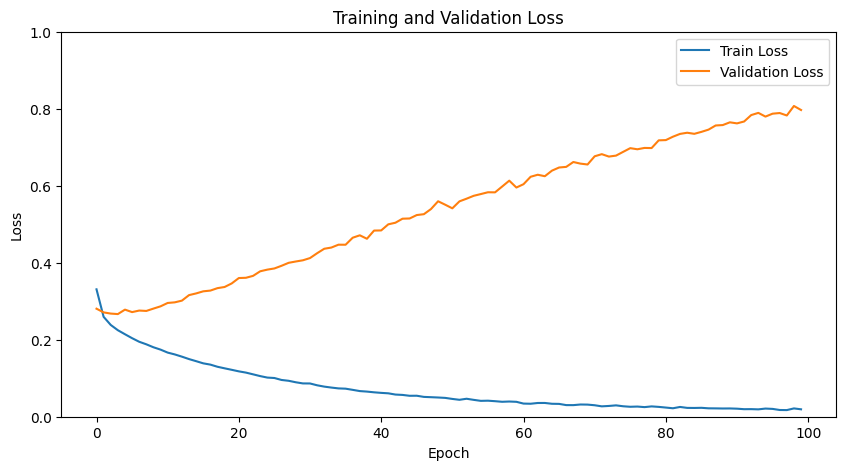

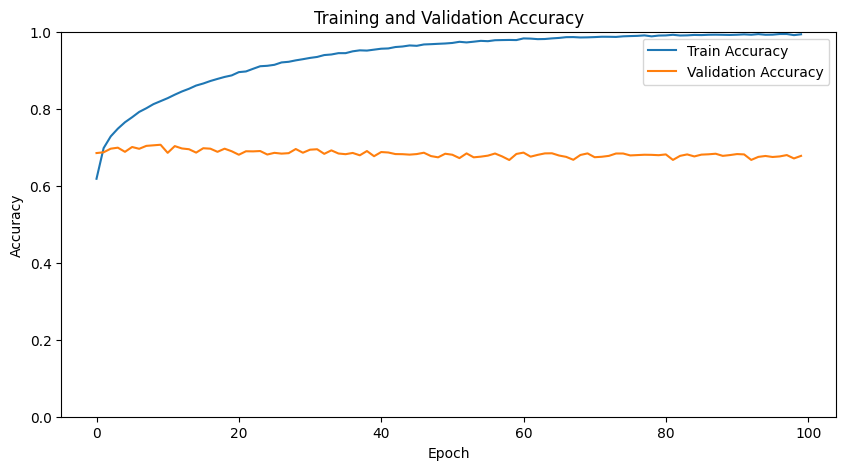

In [4]:
import matplotlib.pyplot as plt

# Get the training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0, 1])
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pickle

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L_20.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L_20.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+19, 'gx'].values
    gy_values = train_df.loc[i:i+19, 'gy'].values
    gz_values = train_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append([gx_values, gy_values, gz_values])

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+19, 'gx'].values
    gy_values = test_df.loc[i:i+19, 'gy'].values
    gz_values = test_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append([gx_values, gy_values, gz_values])

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
y_test = onehot_encoder.transform(integer_encoded_test)

# LSTM 모델 정의
model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(3, 20)))  # 3개의 시퀀스, 각 시퀀스에 40개의 피처
model.add(keras.layers.Dense(5, activation='softmax'))  # 분류할 클래스 수에 맞게 조정

# 모델 컴파일 및 학습
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = history.model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_lstm.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_lstm.npy', label_encoder.classes_)

# 가중치를 로드하기 위해 모델 구성
loaded_model = keras.models.Sequential()
loaded_model.add(keras.layers.LSTM(128, input_shape=(3, 20)))  # 3개의 시퀀스, 각 시퀀스에 40개의 피처
loaded_model.add(keras.layers.Dense(5, activation='softmax'))  # 분류할 클래스 수에 맞게 조정

# 피클 파일에서 가중치 로드
loaded_model_weights = pickle.load(open('../model/best_model_weights_lstm.pkl', 'rb'))

# 모델에 로드된 가중치 설정
loaded_model.set_weights(loaded_model_weights)

# 모델 컴파일
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 저장
loaded_model.save('../model/loaded_model_lstm.h5')

Epoch 1/100
427/427 [==============================] - 3s 4ms/step - loss: 1.0523 - accuracy: 0.5757 - val_loss: 0.8567 - val_accuracy: 0.6669
Epoch 2/100
427/427 [==============================] - 1s 3ms/step - loss: 0.7163 - accuracy: 0.7119 - val_loss: 0.8137 - val_accuracy: 0.6809
Epoch 3/100
427/427 [==============================] - 1s 3ms/step - loss: 0.6036 - accuracy: 0.7594 - val_loss: 0.8248 - val_accuracy: 0.6838
Epoch 4/100
427/427 [==============================] - 1s 3ms/step - loss: 0.5250 - accuracy: 0.7938 - val_loss: 0.8306 - val_accuracy: 0.6797
Epoch 5/100
427/427 [==============================] - 1s 3ms/step - loss: 0.4660 - accuracy: 0.8200 - val_loss: 0.9033 - val_accuracy: 0.6657
Epoch 6/100
427/427 [==============================] - 1s 3ms/step - loss: 0.4104 - accuracy: 0.8468 - val_loss: 0.8909 - val_accuracy: 0.6721
Epoch 7/100
427/427 [==============================] - 1s 3ms/step - loss: 0.3647 - accuracy: 0.8673 - val_loss: 0.9021 - val_accuracy: 0.6832

KeyboardInterrupt: 